<a href="https://colab.research.google.com/github/llafcode/IntroDL_EX03_AutoLyrics/blob/master/EX03_Chang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation



This code installs a time utility to measure run time of cells.

In [42]:
%%capture
!pip install ipython-autotime

%load_ext autotime

time: 3.13 s


The dataset was uploaded to [llafcode/IntroDL_EX03_AutoLyrics](https://github.com/llafcode/IntroDL_EX03_AutoLyrics), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `test_path` - the test dataset path



In [15]:
%%capture
import os

# Clone the entire repo.
!git clone -s git://github.com/llafcode/IntroDL_EX03_AutoLyrics.git AutoLyrics
repo_path = os.path.join(os.getcwd(), 'AutoLyrics')
melody_path = os.path.join(repo_path, 'data', 'midi_files')
train_data = os.path.join(repo_path, 'data', 'lyrics_train_set.csv')
test_data = os.path.join(repo_path, 'data', 'lyrics_test_set.csv')

time: 1.75 s


Next, we install TensorFlow 2.0 and import it

In [16]:
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install -q tensorflow-gpu==2.0.0-alpha0
#!pip install -q tf-nightly-gpu-2.0-preview

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

# For potential eager executions
# tf.enable_eager_execution()

time: 6.57 ms


For reproducible results, we init numpy and tensorflow random seed with same values

In [17]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
np.random.seed(2)
# tf.random.set_seed(2)

# Make sure we are set to GPU (under Runtime->Change runtime type)
print('Running on GPU' if tf.test.is_gpu_available() else 'Please change runtime type to GPU on Google Colab under Runtime')

Running on GPU
time: 12.3 ms


Import pretty midi

In [18]:
import pretty_midi

# For plotting
import mir_eval.display
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

# For putting audio in the notebook
import IPython.display

import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15,15)})
# sns.set_palette('Paired', 12)

time: 7.59 ms


The documentation of Pretty_midi is availabel [here](https://craffel.github.io/pretty-midi/), and a jupyter notebook tutorial is available [here](https://nbviewer.jupyter.org/github/craffel/pretty-midi/blob/master/Tutorial.ipynb).

In [0]:
# Load a single mid file
pm = pretty_midi.PrettyMIDI(os.path.join(melody_path, '1910_Fruitgum_Company_-_Simon_Says.mid'))

time: 737 ms


A great way to visualize MIDI data is via a piano roll, which is a time-frequency matrix where each row is a different MIDI pitch and each column is a different slice in time. pretty_midi can produce piano roll matrices for each indivual instrument (via Instrument.get_piano_roll) or the entire PrettyMIDI object (summed across instruments, via PrettyMIDI.get_piano_roll). The spacing in time between subsequent columns of the matrix is determined by the fs parameter.

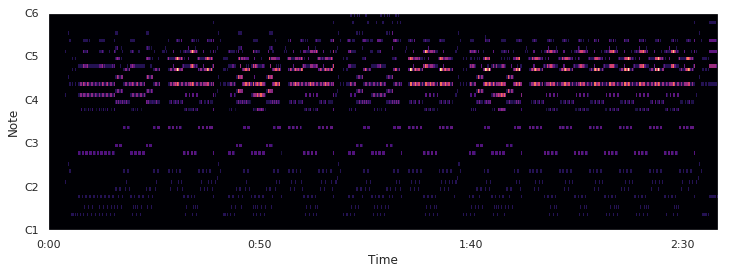

time: 1.71 s


In [0]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
  # Use librosa's specshow function for displaying the piano roll
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                           hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                           fmin=pretty_midi.note_number_to_hz(start_pitch))
  
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [0]:
# The instruments list
print(pm.instruments)

[Instrument(program=18, is_drum=False, name="Organ"), Instrument(program=34, is_drum=False, name="Bass"), Instrument(program=48, is_drum=False, name="Strings"), Instrument(program=67, is_drum=False, name="Melody"), Instrument(program=25, is_drum=False, name="6 String"), Instrument(program=0, is_drum=False, name="12 String"), Instrument(program=0, is_drum=False, name="Chips"), Instrument(program=61, is_drum=False, name="Brass"), Instrument(program=53, is_drum=False, name="Syn Vox"), Instrument(program=0, is_drum=True, name="Kick"), Instrument(program=16, is_drum=False, name="Solo Organ")]
time: 2.95 ms


In [0]:
# Listen it!
# IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

time: 509 µs


In [0]:
# Let's look at what's in this MIDI file
print(f'There are {len(pm.time_signature_changes)} time signature changes')
print(f'There are {len(pm.instruments)} instruments')
print(f'Instrument 3 has {len(pm.instruments[2].notes)} notes')
print(f'Instrument 4 has {len(pm.instruments[3].pitch_bends)} pitch bends')
print(f'Instrument 5 has {len(pm.instruments[4].control_changes)} control changes')

There are 1 time signature changes
There are 11 instruments
Instrument 3 has 155 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 4 control changes
time: 5.64 ms


# Dataset analysis

In the csv file, there are more than three columns. We are currently not sure what are the other columns, and for the initial experiment, we start with only the first three columns.

In [19]:
def remove_noise_char(lyrics):
  # Replace '' with " (later remove it)
  ret = lyrics.str.replace(r"''", '"')
  
  # Replace ` with '
  ret = ret.str.replace(r'`', "'")
  
  # Replace / with - (appears in 24/7)
  ret = ret.str.replace(r'/', '-')

  # Replace three ? with one
  ret = ret.str.replace('\?\?\?', '?')

  # Replace all brackets, :;#", and weird chars
  ret = ret.str.replace(r'[\[\]()\{\}:;#\*"ã¤¼©¦­]', '')
  
  # Remove certain words
  for word in ['chorus', '\-\-\-', '\-\-']:
    ret = ret.str.replace(word, '')
    
  # Replace these words with space
  for word in ['\.\.\.\.\.', '\.\.\.\.', '\.\.\.', '\.\.', " '"]:
    ret = ret.str.replace(word, ' ')
    
  # Remove duplicate spaces
  ret = ret.apply(lambda s: ' '.join(s.split()))
  return ret

time: 9.26 ms


In [20]:
from collections import Counter

def plot_word_freq(column):
  counts = Counter(word_tokenize(column.str.cat(sep=' ')))
  labels, values = zip(*counts.items())
  
  print(f'Total number of words (raw): {len(labels)}')
  
  plt.plot(values)
  plt.show()
  
  return labels

time: 3.4 ms


In [21]:
df_train = pd.read_csv(train_data, usecols=[0,1,2], names=['author', 'song', 'lyrics'])
df_train.head()

,author,song,lyrics
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...


time: 35.8 ms


In [22]:
df_train['lyrics'] = remove_noise_char(df_train.lyrics)

time: 228 ms


Total number of words (raw): 7436


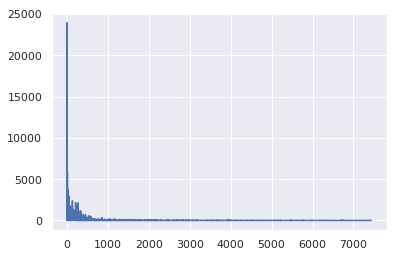

time: 923 ms


In [23]:
import nltk
nltk.download('punkt', quiet=True)
from nltk import word_tokenize

vocab = plot_word_freq(df_train.lyrics)

# A lyric generation approach using LSTM (without melodies)

## Using pretrained word2vec (Glove)


We need to download the pre-trained Glove word2vec from [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove_pretrained


--2019-07-20 13:21:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-07-20 13:21:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-07-20 13:21:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
pre_trained_embedding = 'glove_pretrained/glove.6B.300d.txt'

# Load the pre-trained Glove Word2Vec embeddings
def load_embedding(filename):
  """
  input:
  @filename: a .txt file of the pre-trained word2vec embedding
  
  output:
  @embedding: a dictionary of word vectors. Keys are distinct words and values are the word vectors
  """
  with open(filename, 'r') as f:
    lines = f.readlines()
    
  embedding = {}
  for line in lines:
      parts = line.split()
      # key is string word, value is numpy array for vector
      embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
  return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    """
    input:
    @embedding: dictionary of word vectors (all words in the pre-trained model)
    @vocab: vocabulary of the lyrics dataset
    
    output:
    @weight_matrix: a n*300 numpy array, where n is the total number of words in the vocabulary.
                    each row of this matrix is a 300 dimension word vector of the ith word in vocab.
    """
    
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab)
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for i, word in enumerate(vocab):
        # print("Getting word %i, which is %s" % (i, word))
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

time: 17.3 ms


In [25]:
raw_embedding = load_embedding(pre_trained_embedding)
word_vectors = get_weight_matrix(raw_embedding, vocab)

time: 25 s


## Prepare input and output of the network
The input should be a sequence of words (could be one, or n-gram) and the output should be the next word. Therefore during training, we need to specify a n-gram length (>=1) as input for each timestamp, and the next word as the output of this timstamp.

In [26]:
word_to_indices = dict((c, i) for i, c in enumerate(vocab))
indices_to_word = dict((i, c) for i, c in enumerate(vocab))

def prepare_input_output(all_lyrics, n=1):
  """
  input:
  @all_lyrics: numpy array of strings. All lyric text in the training set
  @n: n-gram size, n>=1. n=1 means the length of the context is 1, n=2 means there are two words in the context.
  
  output:
  @context: numpy array of indices of context words
  @next_word: numpy array of indices of next word with the specific context
  """
  context = []
  next_words = []
  
  for song in all_lyrics:
    # Tokenize the lyrics of one song
    lyric_words = word_tokenize(song)
    for i in range(0, len(lyric_words) - n):
      context.append([word_to_indices[w] for w in lyric_words[i : i+n]])
      next_words.append(word_to_indices[lyric_words[i+n]])
  return np.array(context), np.array(next_words)
  

time: 16.7 ms


In [27]:
train_lyrics = df_train['lyrics'].values
context, next_words = prepare_input_output(train_lyrics, n=1)

time: 1.21 s


In [28]:
for i in range(5):
  print(context[i], next_words[i])

[0] 1
[1] 2
[2] 3
[3] 4
[4] 5
time: 2.42 ms


## Build the network

In [29]:
# Instead of choosing the word with highest probability, 
# we choose the next word by sampling from the output probability distribution
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

time: 3.91 ms


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import CuDNNLSTM as LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import np_utils

time: 4.24 ms


In [35]:
# define model
embedding_layer = Embedding(len(vocab), 300, weights=[word_vectors], trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(300))
model.add(Dense(len(vocab), activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         2230800   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 300)               722400    
_________________________________________________________________
dense_1 (Dense)              (None, 7436)              2238236   
Total params: 5,191,436
Trainable params: 2,960,636
Non-trainable params: 2,230,800
_________________________________________________________________
None
time: 305 ms


In [44]:
lr = 0.5
optimizer = Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

time: 55.7 ms


In [0]:
model.fit(context, next_words, epochs=50)

Epoch 1/50
190849/190849 [==============================] - 23s 121us/sample - loss: 3.8628 - acc: 0.2492
Epoch 2/50
190849/190849 [==============================] - 22s 117us/sample - loss: 3.7704 - acc: 0.2500
Epoch 3/50
190849/190849 [==============================] - 23s 119us/sample - loss: 3.7387 - acc: 0.2500
Epoch 4/50
190849/190849 [==============================] - 22s 117us/sample - loss: 3.7236 - acc: 0.2493
Epoch 5/50
190849/190849 [==============================] - 22s 115us/sample - loss: 3.7146 - acc: 0.2500
Epoch 6/50
190849/190849 [==============================] - 22s 114us/sample - loss: 3.7101 - acc: 0.2495
Epoch 7/50
190849/190849 [==============================] - 22s 115us/sample - loss: 3.7035 - acc: 0.2506
Epoch 8/50
190849/190849 [==============================] - 23s 120us/sample - loss: 3.7020 - acc: 0.2502
Epoch 9/50
190849/190849 [==============================] - 23s 118us/sample - loss: 3.6978 - acc: 0.2501
Epoch 10/50
190849/190849 [===================

In [43]:
print(vocab[5])
pred = model.predict(context[5])
indices_to_word[sample(pred.reshape(-1))]

i


'was'

time: 104 ms


In [33]:
initial_word = 'i'
output_length = 300
output_sentence = [initial_word]
prev_word = initial_word

for i in range(output_length - 1):
  pred = model.predict(context[vocab.index(prev_word)])
  next_word = indices_to_word[sample(pred.reshape(-1))]
  output_sentence.append(next_word)

time: 759 ms


In [34]:
print(' '.join(output_sentence))

i 'm cross 'm 'll do feel want ca see 'm dial fought did 've wan say 'm 'd heard want 'll come only see guess look tell 'm 'm do thank can got 'd could found was think 'm say 'm 'm be see 'm can need do have just 'll wan 'm 'm know saw could wo was have 'm 'm do am knew just 'm only broke wait ca want fall remember remember just think 've 've could 'm got 'll 'll mean really could could 'll 'll got 'm love 'm 'll can lose could find feel 'm 'm go 'm just ca 've would never say will am want have am should what was got wan get can know think do kissed fought 'll 'm 'd 'll 'll just just would 'm not 'm would 'll just 'm will saw ai never 'm can can do am never ca never ca am 've heard 'm i 'll want stick know can 'm break 'm 'll wo know know feel did 've go 'm do like 'd were 'm 'll do know ca just do wish you do see had never 've 'm 'm love do just get got 'll swear 'm feel 'm cross breathe love could would do forgot do 'm 'm 'm do 'm do have do 've 'd wan really need 'll want saw 'm was

In [0]:
%%capture
# !python -m nltk.downloader all

time: 458 µs


In [0]:
# import nltk
# nltk.download('punkt', quiet=True)
# from nltk import word_tokenize

time: 33 ms
